## Not ready yet!

## ECE495 Intro to programming neurons with Nengo: Transformation

In this demonstration we will:

1. Add using a single neuron
2. Discuss decoders in more depth
3. Perform simple mathematical computations using neurons (such as squaring values)
4. Perform mathematical computations that require 2-D neurons (such as multiplication)
5. Utilize greater than 2-D neurons to compute matrix multiplication

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import nengo
from nengo.utils.matplotlib import rasterplot
from nengo.dists import Uniform

### Addition using neurons

Do you think you need multiple neurons to add, or can a single neuron do it alone?

Inputs to a neuron ensemble are spike rates. Higher spike rates represent higher values, lower rates for lower values. If the neuron ensemble is recieving all of these spikes and passing along the info, the spike rate out is the combined rate.

Think through this: all neurons are firing at 100Hz over 1 second and you're wanting to add a value of .2 (20 spikes) to .3 (30 spikes). That means your adder neuron ensemble receives 50 spikes. What value would that decode to for a firing rate of 100Hz?? 

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


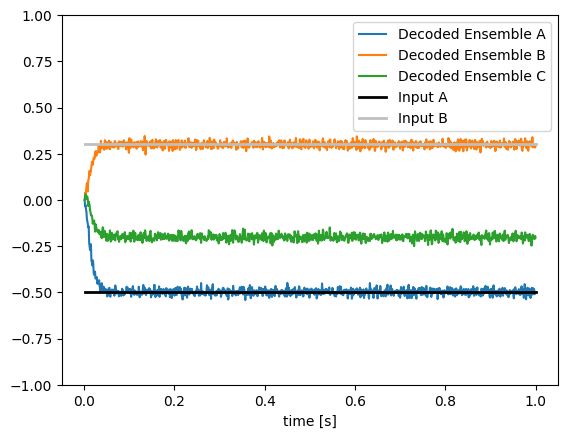

In [67]:

# Create the model object
model = nengo.Network(label="Addition")
with model:
    # Create 3 ensembles each containing 100 leaky integrate-and-fire neurons
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)
    C = nengo.Ensemble(100, dimensions=1)

with model:
    # Create input nodes representing constant values
    input_a = nengo.Node(output=-0.5)
    input_b = nengo.Node(output=0.3)

    # Connect the input nodes to the appropriate ensembles
    nengo.Connection(input_a, A)
    nengo.Connection(input_b, B)

    # Connect input ensembles A and B to output ensemble C
    nengo.Connection(A, C)
    nengo.Connection(B, C)

with model:
    input_a_probe = nengo.Probe(input_a)
    input_b_probe = nengo.Probe(input_b)
    A_probe = nengo.Probe(A, synapse=0.01)
    B_probe = nengo.Probe(B, synapse=0.01)
    C_probe = nengo.Probe(C, synapse=0.01)
    spikesA = nengo.Probe(A.neurons)
    spikesB = nengo.Probe(B.neurons)
    spikesC = nengo.Probe(C.neurons)

# Create the simulator
with nengo.Simulator(model) as sim:
    # Run it for 5 seconds
    sim.run(1)

# Plot the input signals and decoded ensemble values
t = sim.trange()
plt.figure()
plt.plot(sim.trange(), sim.data[A_probe], label="Decoded Ensemble A")
plt.plot(sim.trange(), sim.data[B_probe], label="Decoded Ensemble B")
plt.plot(sim.trange(), sim.data[C_probe], label="Decoded Ensemble C")
plt.plot(
    sim.trange(), sim.data[input_a_probe], label="Input A", color="k", linewidth=2.0
)
plt.plot(
    sim.trange(), sim.data[input_b_probe], label="Input B", color="0.75", linewidth=2.0
)
plt.legend()
plt.ylim(-1, 1)
plt.xlabel("time [s]")
plt.show()

If this is not intuitive to you, I encourage you to use a single neuron to encode .2 at 100Hz and a single neuron to encode .3 at 100Hz. View your output spikes. Add them together using a third (single) neuron at 100Hz and view the output spikes.

#### Let's talk decoders (again)

Adding is easy! But what if you want to do something a little more complex - say, $2x+y$? This requires us to dive into decoders once more.

Recall (from neuron representation): We multiply our "filtered spike trains" with decoding weights and sum them together to give an estimate of the input based on the spikes (i.e. our decoded signal). The decoding weights assign weights to each neuron output based on how important that is to approximating the signal (i.e. more important = higher amplitude/weight when added together). 

Nengo trains decoding weights - similar to weights of a neural network - that are used to reconstruct the input value via spiking neuron outputs. The decoding weights are determined by minimizing the squared difference between the decoded estimate and the actual input signal. Nengo does this for us and we can get our decoding values from our model. Because weights are trained values between neuron layers, we must get the weights from a connection.

There is a really [helpful video](https://youtu.be/JCA2gOhN5oM?si=S0Pj-T4NoHHfEEuO&t=5576) to understand how these decoder weights can be learned in real-time - great for edge computing. The whole video is great, but this link should start the video at 1hr32min and will explain how decoders are learned in real-time.

### Communication Channel

To solidify our understanding of decoders, let's connect two neuron ensembles together to represent an input signal:  
[Input] ---> (A) ---> (B) ---> [Output]

We will then assess the decoders and decide if it makes sense.

#### Build your model

In [36]:
# Create a 'model' object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Communications Channel")
with model:
    # Create an abstract input signal that oscillates as sin(t)
    sin = nengo.Node(lambda t: np.sin(2*np.pi*t))

    # Create an ouput node to view weights from 2nd ensemble
    out_node = nengo.Node(size_in=1)

    # Create the neuronal ensembles
    A = nengo.Ensemble(100, dimensions=1)
    B = nengo.Ensemble(100, dimensions=1)

    # Connect the input to the first neuronal ensemble
    nengo.Connection(sin, A)

    # Connect the first neuronal ensemble to the second
    # (this is the communication channel)
    decoder_connA = nengo.Connection(A, B)

    # Connect the second neuronal ensemble to the output node
    # (this is where decoders for B are stored)
    decoder_connB =nengo.Connection(B, out_node)

#### Add probes to your model

In [61]:
with model:
    sin_probe = nengo.Probe(sin)
    A_probe = nengo.Probe(A, synapse=0.01)  # ensemble output
    B_probe = nengo.Probe(B, synapse=0.01)

#### Run your model

In [62]:
with nengo.Simulator(model) as sim:
    sim.run(2)

Build finished in 0:00:01.                                                      
Simulation finished in 0:00:01.                                                 


#### View your data

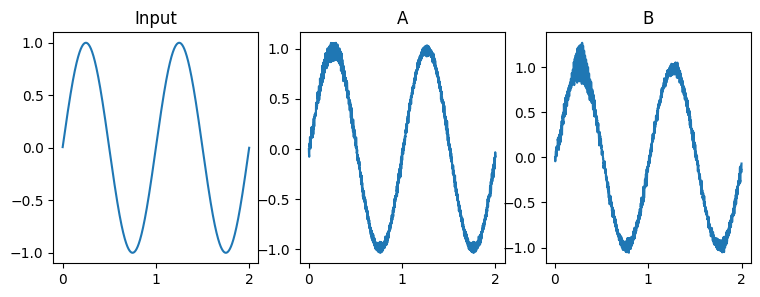

In [63]:
plt.figure(figsize=(9, 3))
plt.subplot(1, 3, 1)
plt.title("Input")
plt.plot(sim.trange(), sim.data[sin_probe])
plt.subplot(1, 3, 2)
plt.title("A")
plt.plot(sim.trange(), sim.data[A_probe])
plt.subplot(1, 3, 3)
plt.title("B")
plt.plot(sim.trange(), sim.data[B_probe])

#### View Decoders

Do you think decoder values for A and B will be the same or different?? Why??

Let's check your intuition:

In [59]:
# probe the weights from the connection between the neuron and output node (out_conn)
with nengo.Simulator(model) as sim:
    decodersA = sim.data[decoder_connA].weights
    decodersB = sim.data[decoder_connB].weights

print(" [  A Decoders   |   B Decoders  ]")
print(np.concatenate((np.transpose(decodersA)[0:20],np.transpose(decodersB)[0:20]), axis=1))

Build finished in 0:00:01.                                                      
 [  A Decoders   |   B Decoders  ]
[[ 3.91131623e-05  5.03339339e-05]
 [-5.37641115e-05 -4.26051060e-05]
 [ 3.86924044e-05 -6.06857063e-05]
 [ 5.20943018e-05  4.66199598e-05]
 [-4.86912679e-05 -6.53872884e-05]
 [-6.08998963e-05 -6.71859898e-05]
 [ 4.38264658e-05  4.10065271e-05]
 [ 3.67773860e-05  7.04141114e-05]
 [ 4.01615864e-05 -6.58569474e-05]
 [-4.12042797e-05  4.56260788e-05]
 [ 8.07729047e-05  5.84289764e-05]
 [-1.20699761e-04  3.99696202e-05]
 [ 5.25156046e-05 -7.58930423e-05]
 [-1.14465527e-04 -8.97476157e-05]
 [-7.27036278e-05 -4.28636803e-05]
 [-1.31155929e-04  6.86970179e-05]
 [ 5.12100567e-05 -4.70440035e-05]
 [-4.46816036e-05  6.04143515e-05]
 [ 6.00030543e-05 -5.18491203e-05]
 [-4.93146402e-05 -6.93133154e-05]]


#### Discussion

Decoder values are computing using least squares, where the decoders minimize the squared difference between the decoded estimate and the actual input signal:

$$<<x-\hat{x}>^2>_x$$

where:

$$\hat{x} = \sum{a_i d_i}$$

with $x$ being the original input signal, $\hat{x}$ being the decoded signal, $a_i$  being neuron activities (i.e. firing rates), and $d_i$ being decoder values.

Now, given that every neuron in a neuron ensemble has randomly set parameters (unless you hand-choose them), we _should not expect the decoders at ensemble A to be equivalent to those at ensemble B_. Suppose our ensemble A parameters are exactly equivalent to ensemble B, then what? Let's see:


In [60]:
# Makes the tuning curves perfectly spaced out
def aligned(n_neurons, radius=0.9):
    intercepts = np.linspace(-radius, radius, n_neurons) # even spaced from -.9 to .9
    encoders = np.tile([[1], [-1]], (n_neurons // 2, 1)) # half care about negative, half positive
    intercepts *= encoders[:, 0]
    return intercepts, encoders

intercepts, encoders = aligned(100)  # Makes evenly spaced intercepts

# Create a 'model' object to which we can add ensembles, connections, etc.
model = nengo.Network(label="Communications Channel 2")
with model:
    # Create an abstract input signal that oscillates as sin(t)
    sin = nengo.Node(lambda t: np.sin(2*np.pi*t))

    # Create an ouput node to view weights from 2nd ensemble
    out_node = nengo.Node(size_in=1)

    # Create the neuronal ensembles
    A = nengo.Ensemble(100,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(100, 100), #evenly distributed between 80 and 100Hz
        encoders=encoders)
    B = nengo.Ensemble(100,
        dimensions=1,
        intercepts=intercepts,
        max_rates=Uniform(100, 100), #evenly distributed between 80 and 100Hz
        encoders=encoders)

    # Connect the input to the first neuronal ensemble
    nengo.Connection(sin, A)

    # Connect the first neuronal ensemble to the second
    # (this is the communication channel)
    decoder_connA = nengo.Connection(A, B)

    # Connect the second neuronal ensemble to the output node
    # (this is where decoders for B are stored)
    decoder_connB =nengo.Connection(B, out_node)

    # probe the weights from the connection between the neuron and output node (out_conn)
with nengo.Simulator(model) as sim:
    decodersA = sim.data[decoder_connA].weights
    decodersB = sim.data[decoder_connB].weights

print(" [  A Decoders   |   B Decoders  ]")
print(np.concatenate((np.transpose(decodersA)[0:20],np.transpose(decodersB)[0:20]), axis=1))

Build finished in 0:00:01.                                                      
 [  A Decoders   |   B Decoders  ]
[[ 1.95904369e-04  1.95880588e-04]
 [-9.72666951e-05 -9.75266690e-05]
 [ 1.97678530e-04  1.97670131e-04]
 [-9.44478936e-05 -9.47192656e-05]
 [ 2.01992160e-04  2.01888212e-04]
 [-9.60119846e-05 -9.60308684e-05]
 [ 2.07153753e-04  2.07097781e-04]
 [-1.01057116e-04 -1.01080164e-04]
 [ 2.12309581e-04  2.12309857e-04]
 [-1.07762153e-04 -1.07919223e-04]
 [ 2.17250515e-04  2.17167601e-04]
 [-1.15457684e-04 -1.15374655e-04]
 [ 2.21823907e-04  2.21758108e-04]
 [-1.23772411e-04 -1.23708233e-04]
 [ 2.25854861e-04  2.25848337e-04]
 [-1.31851703e-04 -1.31982912e-04]
 [ 2.29614556e-04  2.29549352e-04]
 [-1.40316214e-04 -1.40168352e-04]
 [ 2.32846843e-04  2.32854291e-04]
 [-1.48462048e-04 -1.48389393e-04]]


The weights are _the same_! However, notice that the decoded signals are a little noiser. This may be becuase we do not adequately span the space of our signal. With more variety of neuron parameters, we can better capture the complexity of the signal.

### Simple computations using neurons and their decoders

So, why did we hit decoders _again_?? 

Encoding and decoding allow us to encode signals over time, and decode transformations of those signals. So far, we've only decoded the signal itself (i.e. a boring but necessary to understand transformation).

Now, we will decode arbitrary transformations of the input signal. These arbitrary transformations are functions performed on our neuron activities (i.e. outputs of the neuron ensembles that encode the input signal). These functions are computed by _learning decoder weights that perform the computation_. This means that if we want to square an input signal, the decoder weights will be learned such that when the filtered neuron spikes are weighted and added up, they'll result in the squared value.

If equations are helpful to you, we now have an output that is $f(x)=x^2$. Nengo learns the encoders in the same way as before, except it's now minimizing the difference between the decoded estimate of $\hat{f}(x)=\hat{x}^2$ and the actual computed value $f(x)=x^2$, where $\hat{x}$ is the encoded input signal and $x$ is the actual input signal:   

$$<<f(x)-\hat{f}(x)>^2>_{f(x)}$$

where:

$$\hat{f}(x) = \sum{a_i d_i}$$

Note: these decoders are learned such that it can handle time-varying input so long as the values used fall within the neuron's radius! This means that regardless of input values, these decoder weights should be used able to effectively decode the function outputs. If it's innacurate, you might just need more neurons.

Enough about that, let’s decode the square of a white noise input: